In [53]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Visual Settings
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [54]:
sheet_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR0M3el91RhbVIQcfn9g2KjsOl8IcmJacgq4e1NVV4DlxNtFjIMrfY87nadi_vtZvhwcWPaTr4vCpdS/pub?output=csv'

In [55]:
portfolio_df = pd.read_csv(sheet_url)
portfolio_df['Shares'] = pd.to_numeric(portfolio_df['Shares'], errors='coerce')
portfolio_df = portfolio_df.dropna(subset=['Ticker'])

In [56]:
try:

    portfolio_df = pd.read_csv(sheet_url, dtype=str)

    # Cleaning
    portfolio_df.columns = portfolio_df.columns.str.strip()
    if 'Shares' in portfolio_df.columns:
        portfolio_df['Shares'] = portfolio_df['Shares'].str.replace(',', '.', regex=False)
        portfolio_df['Shares'] = pd.to_numeric(portfolio_df['Shares'], errors='coerce')

    # 3. Eliminate the rows without ticker
    portfolio_df = portfolio_df.dropna(subset=['Ticker'])
    print(portfolio_df.head())
    print(portfolio_df.dtypes)


except Exception as e:
    print(f"❌ ERROR: {e}")

   Ticker  Shares
0  CNDX.L   0.805
1    META   1.000
2    AMZN   2.100
3    ORCL   1.400
4   XIACY   9.000
Ticker     object
Shares    float64
dtype: object


In [57]:
tickers_list = portfolio_df['Ticker'].tolist()

In [61]:
market_data = yf.download(tickers_list,start='2024-08-15' )['Close']
market_data = market_data.dropna()

/tmp/ipython-input-872920921.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(tickers_list,start='2024-08-15' )['Close']
[*********************100%***********************]  10 of 10 completed


In [62]:
market_data.head()

Ticker,ABAT,AMZN,BBAI,CNDX.L,HIVE,LAES,META,NFLX,ORCL,XIACY
Date,,,,,,,,,,
2024-08-15,1.050,177.589996,1.29,1108.324951,2.88,0.426,534.699158,66.321999,134.920639,11.13
2024-08-16,1.030,177.059998,1.26,1110.329956,3.05,0.465,524.837585,67.406998,135.452713,11.15
2024-08-19,1.060,178.220001,1.37,1118.099976,3.07,0.580,526.688660,68.852997,135.896103,11.40
2024-08-20,1.070,178.880005,1.33,1126.400024,3.08,0.561,524.151062,69.853996,137.127762,11.29
2024-08-21,1.055,180.110001,1.69,1129.810059,3.31,0.605,532.539673,69.711998,138.142639,11.68


In [63]:
latest_prices = market_data.iloc[-1]
valuation_df = portfolio_df.copy()
valuation_df.set_index('Ticker', inplace=True)

In [64]:
valuation_df['Live Price'] = latest_prices[valuation_df.index]
valuation_df['Market Value'] = valuation_df['Shares'] * valuation_df['Live Price']

In [65]:
total_value = valuation_df['Market Value'].sum()
valuation_df['Weight %'] = valuation_df['Market Value'] / total_value

In [66]:
total_value

np.float64(3460.705019159317)

In [67]:
daily_returns = market_data.pct_change().dropna()

In [68]:
normalized_prices = (market_data / market_data.iloc[0]*100)

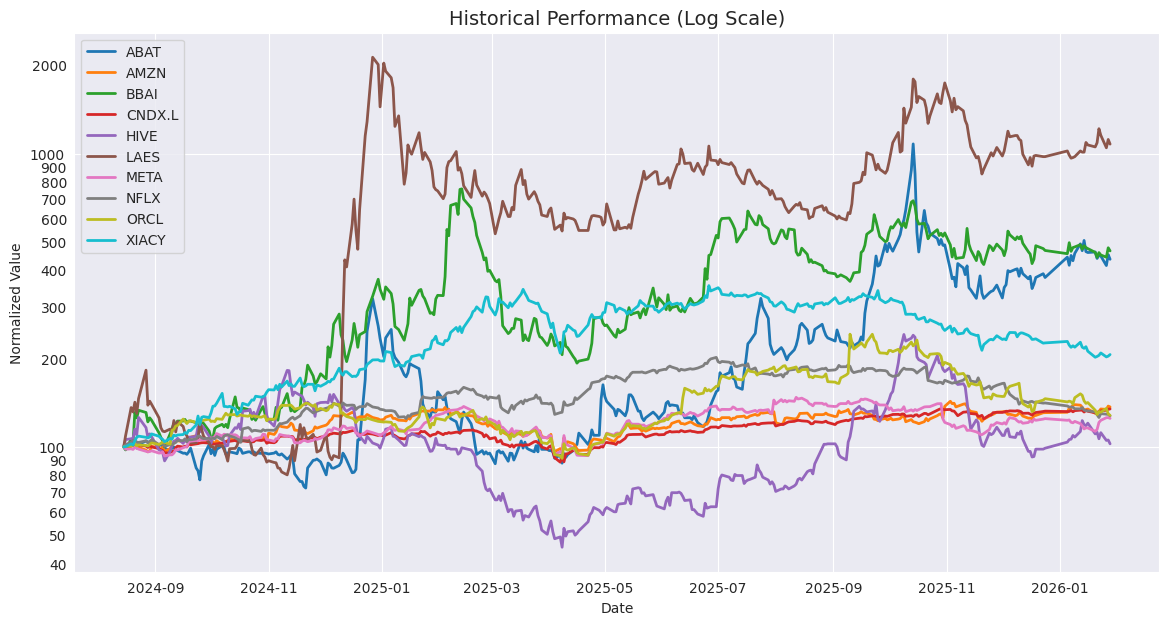

In [69]:
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(14,7))
for col in normalized_prices.columns:
    plt.plot(normalized_prices[col],label=col,linewidth=2)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

plt.title('Historical Performance (Log Scale)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [71]:
weights = valuation_df['Weight %'].values
portfolio_daily_returns = (market_data.pct_change().dropna()*weights).sum(axis=1)

In [72]:
import matplotlib.ticker as mtick
cumulative_returns = (1+portfolio_daily_returns).cumprod()
running_max= cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max)/running_max

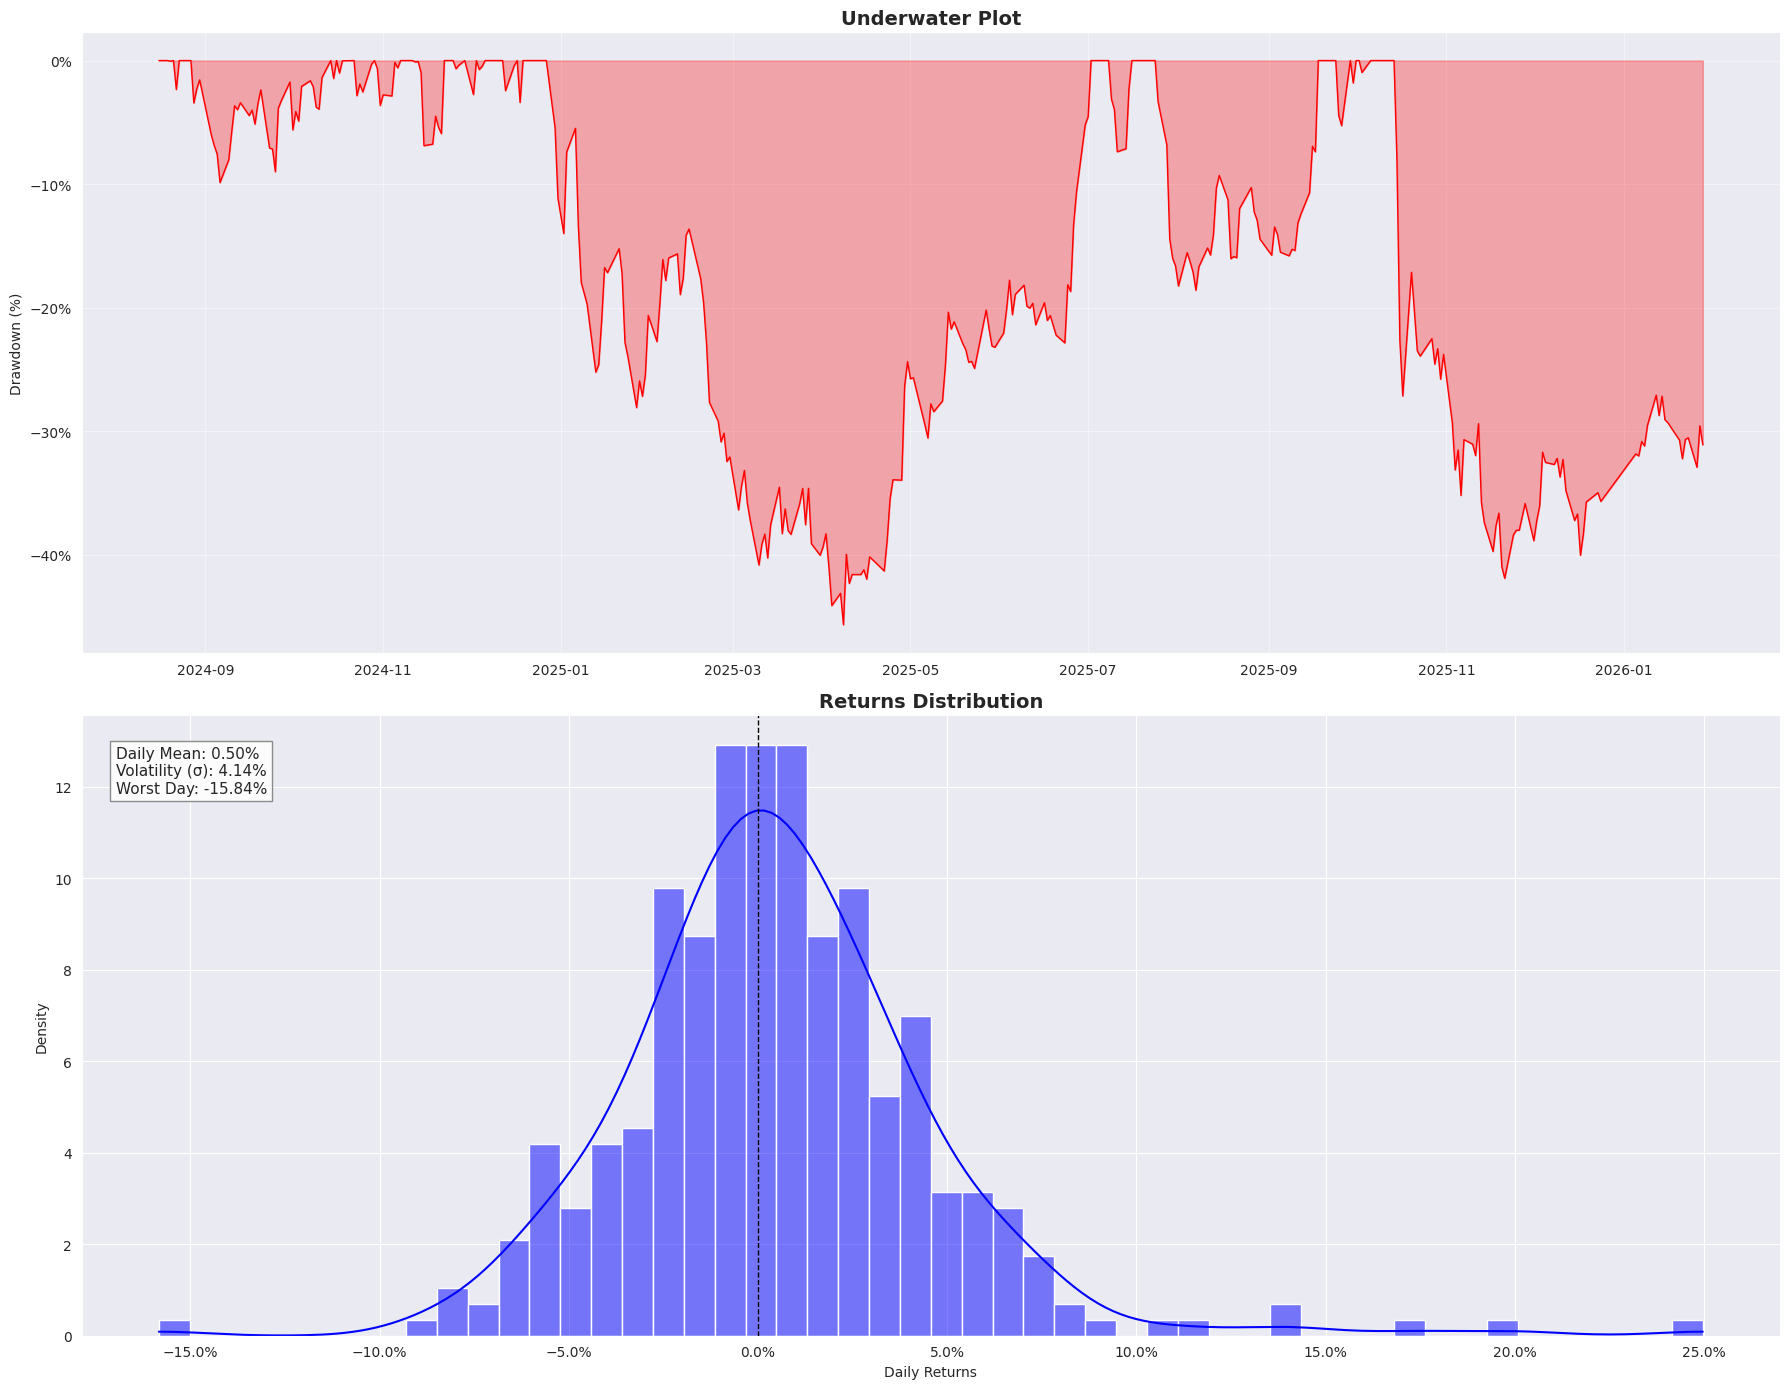

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
#Underwater Plot
ax1.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
ax1.plot(drawdown.index, drawdown, color='red', linewidth=1)
ax1.set_title('Underwater Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown (%)')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format Y as %
ax1.grid(True, alpha=0.5)

#Histogram
sns.histplot(portfolio_daily_returns, bins=50, kde=True, color='blue', ax=ax2, stat='density')
ax2.axvline(0,color='black',linestyle='--',linewidth=1)
ax2.set_title('Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Daily Returns')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#Key Statistics
mean_ret = portfolio_daily_returns.mean()
sigma = portfolio_daily_returns.std()
worst_day = portfolio_daily_returns.min()

stats_text = (f"Daily Mean: {mean_ret:.2%}\n"
              f"Volatility (σ): {sigma:.2%}\n"
              f"Worst Day: {worst_day:.2%}")


ax2.text(0.02, 0.95, stats_text, transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'),
         verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

In [74]:
#Monte Carlo Simulation
SIMULATIONS = 1000
TIME_HORIZON = 252
INITIAL_PORTFOLIO = total_value
mu = portfolio_daily_returns.mean()
sigma = portfolio_daily_returns.std()

random_shocks = np.random.normal(mu,sigma,(SIMULATIONS,TIME_HORIZON))

simulated_paths = np.zeros((SIMULATIONS,TIME_HORIZON))
simulated_paths[0] = INITIAL_PORTFOLIO

for t in range(1,TIME_HORIZON):
    simulated_paths[t] = simulated_paths[t-1] * (1+random_shocks[t])
print("Simulation is complete!")

Simulation is complete!


/tmp/ipython-input-918075985.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')


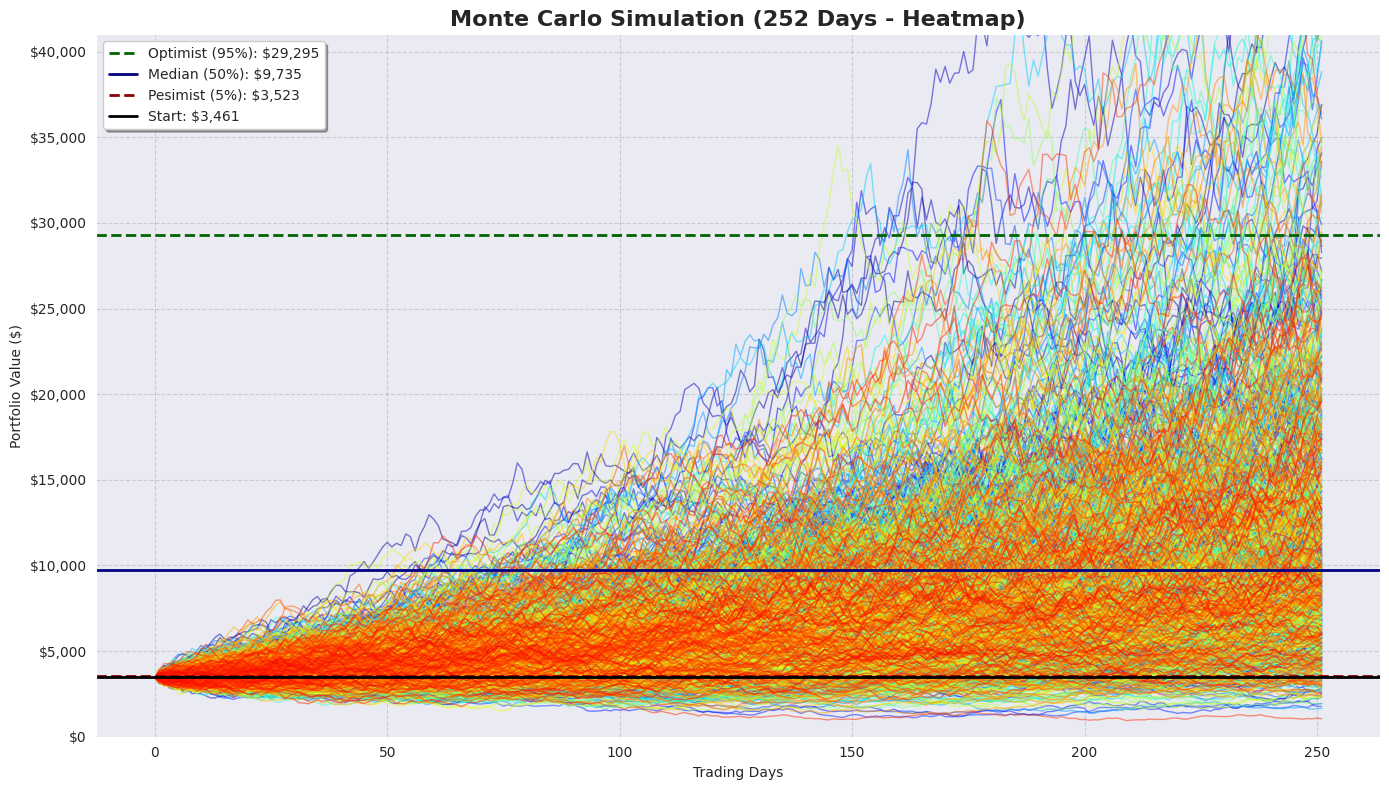

Final Result(1Year Estimation):
   Best Case (Top 5%): $29,294.80
   Median (Expected):   $9,735.32
   Pessimistic (Bottom 5%): $3,522.64


In [75]:
# MONTE CARLO SIMULATION
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick

# 1. Settings
SIMULATIONS = 1000
TIME_HORIZON = 252       # 1 Year
start_val = total_value

# We calculate Mu and Sigma from the historical data
mu = portfolio_daily_returns.mean()
sigma = portfolio_daily_returns.std()


# 2. Generating The Scenarios
random_shocks = np.random.normal(mu, sigma, (TIME_HORIZON, SIMULATIONS))

# We build the prices
simulated_paths = np.zeros((TIME_HORIZON, SIMULATIONS))
simulated_paths[0] = start_val

for t in range(1, TIME_HORIZON):
    simulated_paths[t] = simulated_paths[t-1] * (1 + random_shocks[t])

# 3. Visualisation
plt.figure(figsize=(14, 8))


colormap = cm.get_cmap('jet')
colors = [colormap(i) for i in np.linspace(0, 0.9, SIMULATIONS)]

for i in range(SIMULATIONS):
    plt.plot(simulated_paths[:, i], color=colors[i], linewidth=1, alpha=0.5, zorder=1)

# 4. Percentiles
final_values = simulated_paths[-1]
top_95 = np.percentile(final_values, 95)   # Best Case
median_50 = np.percentile(final_values, 50) # Median
bottom_5 = np.percentile(final_values, 5)   # Worst Case (VaR)

# Desenăm liniile groase peste cele colorate
plt.axhline(top_95, color='darkgreen', linestyle='--', linewidth=2, label=f'Optimist (95%): ${top_95:,.0f}', zorder=2)
plt.axhline(median_50, color='navy', linestyle='-', linewidth=2, label=f'Median (50%): ${median_50:,.0f}', zorder=2)
plt.axhline(bottom_5, color='darkred', linestyle='--', linewidth=2, label=f'Pesimist (5%): ${bottom_5:,.0f}', zorder=2)
plt.axhline(start_val, color='black', linewidth=2, label=f'Start: ${start_val:,.0f}', zorder=2)

# 5. Final Formats
plt.ylim(0, top_95 * 1.4)

plt.title(f'Monte Carlo Simulation ({TIME_HORIZON} Days - Heatmap)', fontsize=16, fontweight='bold')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')


fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)


plt.legend(loc='upper left', frameon=True, framealpha=1, facecolor='white', shadow=True)
plt.grid(True, alpha=0.3, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

# Raport Text Scurt
print(f"Final Result(1Year Estimation):")
print(f"   Best Case (Top 5%): ${top_95:,.2f}")
print(f"   Median (Expected):   ${median_50:,.2f}")
print(f"   Pessimistic (Bottom 5%): ${bottom_5:,.2f}")

In [78]:
#Efficiency adn Risk-Adjusted Metrics
start_date_analysis = market_data.index[0]
end_date_analysis = market_data.index[-1]

# Use spy_ticker variable instead of hardcoded 'SPY'
spy_ticker= 'SPY'
benchmark_raw = yf.download(spy_ticker,start=start_date_analysis, end=end_date_analysis)['Close']

spy_returns = benchmark_raw.pct_change()


aligned_data = pd.DataFrame({
    'Portfolio': portfolio_daily_returns,
    'Benchmark': spy_returns[spy_ticker]
}).dropna()
# FIX END

RISK_FREE_RATE = 0.04
rf_daily = RISK_FREE_RATE/252

#BETA
covariance = aligned_data.cov().iloc[0,1]
market_variance = aligned_data['Benchmark'].var()
beta = covariance/market_variance

#Alpha
port_return_ann = aligned_data['Portfolio'].mean()*252
benchmark_return_ann = aligned_data['Benchmark'].mean() *252
alpha = port_return_ann - (RISK_FREE_RATE + beta * (benchmark_return_ann-RISK_FREE_RATE))

#Sharpe Ratio
excess_returns = aligned_data['Portfolio'] - rf_daily
# FIX: Corrected typo 'aligned_dta' to 'aligned_data'
sharpe = (excess_returns.mean()/aligned_data['Portfolio'].std()*np.sqrt(252))

#Sortino Ratio
neg_returns = aligned_data.loc[aligned_data['Portfolio']<0,'Portfolio']
downside_std = neg_returns.std()*np.sqrt(252)
sortino = (port_return_ann-RISK_FREE_RATE)/downside_std

#RAPORT FINAL
print("\n" + "="*50)
print("EFFICIENCY SCORECARD")
print("="*50)
print(f"Period Analyzed: {len(aligned_data)} days")

print(f"\n🔹 BETA:        {beta:.2f}")

print(f"\n🔹 ALPHA:       {alpha:.2%}")

print(f"\n🔹 SHARPE:      {sharpe:.2f}")

print(f"\n🔹 SORTINO:     {sortino:.2f}")
print("="*50)

/tmp/ipython-input-4190548838.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_raw = yf.download(spy_ticker,start=start_date_analysis, end=end_date_analysis)['Close']
[*********************100%***********************]  1 of 1 completed


EFFICIENCY SCORECARD
Period Analyzed: 350 days

🔹 BETA:        1.62

🔹 ALPHA:       96.34%

🔹 SHARPE:      1.90

🔹 SORTINO:     3.41


In [79]:
# RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Bollinger Bands
def calculate_bollinger(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = sma + (std * num_std)
    lower = sma - (std * num_std)
    return upper, lower

# 1. List for raport
tech_report = []

# 2. Iteration for every ticker
for ticker in valuation_df.index:
    try:
        prices = market_data[ticker].dropna()


        if len(prices) < 50:
            print(f"⚠️ {ticker}: Prea puține date pentru analiză tehnică.")
            continue


        current_price = prices.iloc[-1]

        # A. RSI 14 Days
        rsi_series = calculate_rsi(prices)
        current_rsi = rsi_series.iloc[-1]

        # B. Bollinger Bands 20 Days
        bb_upper, bb_lower = calculate_bollinger(prices)
        upper_val = bb_upper.iloc[-1]
        lower_val = bb_lower.iloc[-1]

        # C. SMA 50
        sma_50 = prices.rolling(window=50).mean().iloc[-1]

        # ALGO
        signal = "⚪ HOLD"
        details = "Neutral"

        #(Oversold)
        if current_rsi < 35 or current_price < lower_val:
            signal = "🟢 BUY / ACCUMULATE"
            if current_rsi < 30: details = "RSI Oversold (<30)"
            elif current_price < lower_val: details = "Bollinger Breakout (Low)"

        #(Overbought)
        elif current_rsi > 70 or current_price > upper_val:
            signal = "🔴 SELL / TAKE PROFIT"
            if current_rsi > 75: details = "RSI Overheated (>75)"
            elif current_price > upper_val: details = "Bollinger Breakout (High)"

        # Difference from SMA 50
        trend = "📈 UP" if current_price > sma_50 else "📉 DOWN"
        dist_sma = (current_price - sma_50) / sma_50


        tech_report.append({
            'Ticker': ticker,
            'Price': current_price,
            'RSI (14)': round(current_rsi, 1),
            'Trend (SMA50)': trend,
            'Dist vs SMA50': f"{dist_sma:.1%}",
            'Bollinger Status': 'Lower Zone' if current_price < lower_val else ('Upper Zone' if current_price > upper_val else 'Mid Range'),
            'SIGNAL': signal,
            'Reason': details
        })

    except Exception as e:
        print(f"Error at {ticker}: {e}")

# 3. Final DataFrame
dashboard_df = pd.DataFrame(tech_report)

# 4. Dashboard
def color_signals(val):
    color = 'black'
    if 'BUY' in val: color = 'green'
    elif 'SELL' in val: color = 'red'
    return f'color: {color}; font-weight: bold'

def color_rsi(val):
    if val > 70: return 'color: red'
    if val < 30: return 'color: green'
    return 'color: black'

print("\n" + "="*80)
print("🤖 TECHNICAL ANALYSIS DASHBOARD (Real-Time Signals)")
print("="*80)


display(dashboard_df.style.applymap(color_signals, subset=['SIGNAL'])
                 .applymap(color_rsi, subset=['RSI (14)'])
                 .format({'Price': "${:,.2f}"})
                 .hide(axis="index"))


🤖 TECHNICAL ANALYSIS DASHBOARD (Real-Time Signals)


/tmp/ipython-input-1426816960.py:100: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dashboard_df.style.applymap(color_signals, subset=['SIGNAL'])
/tmp/ipython-input-1426816960.py:101: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_rsi, subset=['RSI (14)'])


Ticker,Price,RSI (14),Trend (SMA50),Dist vs SMA50,Bollinger Status,SIGNAL,Reason
CNDX.L,"$1,492.80",55.800000,📈 UP,2.7%,Upper Zone,🔴 SELL / TAKE PROFIT,Bollinger Breakout (High)
META,$668.73,57.000000,📈 UP,4.8%,Mid Range,⚪ HOLD,Neutral
AMZN,$243.01,51.600000,📈 UP,3.9%,Mid Range,⚪ HOLD,Neutral
ORCL,$172.80,36.500000,📉 DOWN,-14.3%,Mid Range,⚪ HOLD,Neutral
XIACY,$22.98,40.200000,📉 DOWN,-10.0%,Mid Range,⚪ HOLD,Neutral
NFLX,$84.64,26.700000,📉 DOWN,-13.9%,Mid Range,🟢 BUY / ACCUMULATE,RSI Oversold (<30)
BBAI,$6.01,50.400000,📉 DOWN,-1.4%,Mid Range,⚪ HOLD,Neutral
LAES,$4.59,59.000000,📈 UP,1.3%,Mid Range,⚪ HOLD,Neutral
HIVE,$2.95,46.700000,📉 DOWN,-10.2%,Mid Range,⚪ HOLD,Neutral
ABAT,$4.58,47.900000,📈 UP,9.8%,Mid Range,⚪ HOLD,Neutral


Generating graphs for 10 stocks...


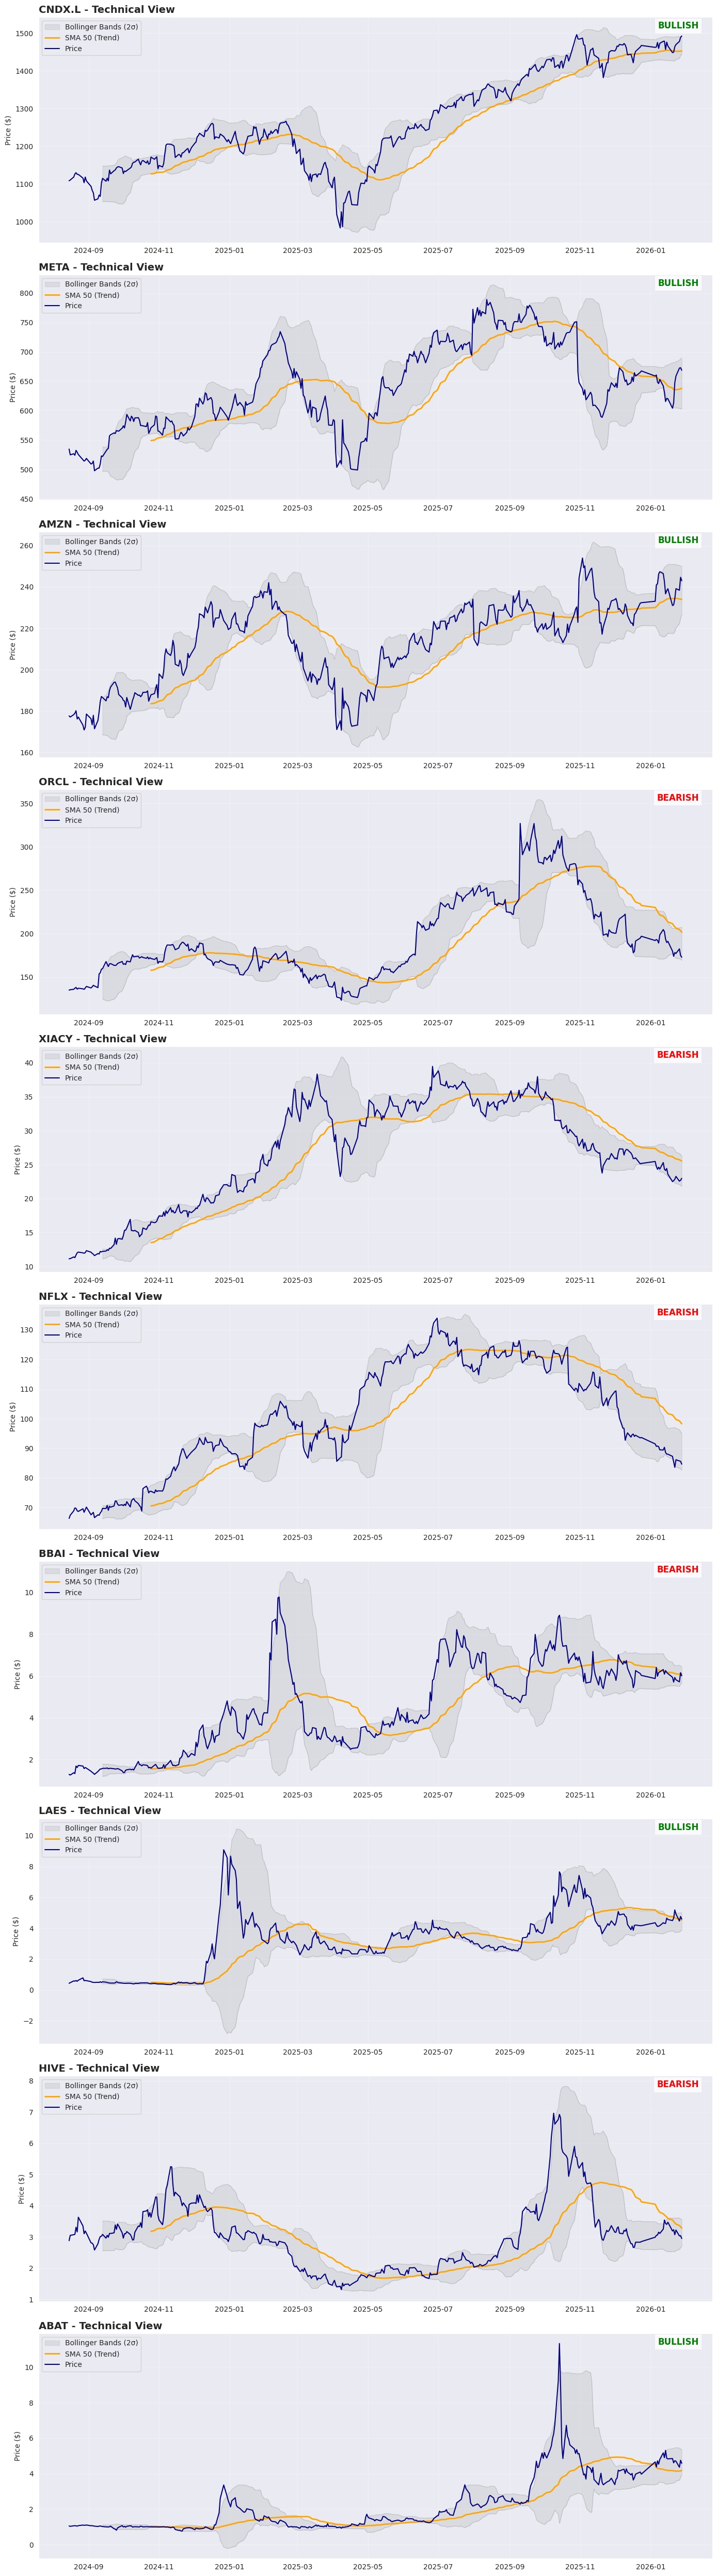

In [80]:
#SMA 50 + Bollinger


assets_to_plot = valuation_df.index.tolist()
num_assets = len(assets_to_plot)

print(f"Generating graphs for {num_assets} stocks...")

fig, axes = plt.subplots(nrows=num_assets, ncols=1, figsize=(14, 5 * num_assets))

if num_assets == 1:
    axes = [axes]

# Iteration for every stock
for i, ticker in enumerate(assets_to_plot):
    ax = axes[i]

    prices = market_data[ticker].dropna()

    sma_50 = prices.rolling(window=50).mean()

    # Bollinger Bands (20 days, 2 Std Deviations)
    sma_20 = prices.rolling(window=20).mean()
    std_20 = prices.rolling(window=20).std()
    bb_upper = sma_20 + (std_20 * 2)
    bb_lower = sma_20 - (std_20 * 2)

    # PLOTTING

    # 1. Bollinger Bands
    ax.fill_between(prices.index, bb_upper, bb_lower, color='gray', alpha=0.15, label='Bollinger Bands (2σ)')
    ax.plot(prices.index, bb_upper, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.plot(prices.index, bb_lower, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # 2. SMA 50
    ax.plot(prices.index, sma_50, color='orange', linewidth=2, label='SMA 50 (Trend)')

    # 3. Actual Price
    ax.plot(prices.index, prices, color='navy', linewidth=1.5, label='Price')

    #
    ax.set_title(f"{ticker} - Technical View", fontsize=14, fontweight='bold', loc='left')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Price ($)')

    last_price = prices.iloc[-1]
    last_sma = sma_50.iloc[-1]

    if pd.notna(last_sma):
        trend_status = "BULLISH" if last_price > last_sma else "BEARISH"
        color_status = "green" if last_price > last_sma else "red"
        ax.text(0.98, 0.95, trend_status, transform=ax.transAxes,
                color=color_status, fontweight='bold', ha='right', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()